First look at the structure of the database
What data does need to be cleaned? How will the transformation look like?

The idea is first and foremost to have a clean database/table to begin with, than to wrangle around .csv files

For future analytics purposes, we push a cleaned "one big table" back to the database.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast 
import os

In [2]:
db = "db/data.db"
try:
    con = sqlite3.connect(db)
    print("Connection succesful.")
    print("Total changes since last commit: ", con.total_changes)
except sqlite3.Error as e:
    print("Error connecting: ", e)

Connection succesful.
Total changes since last commit:  0


In [188]:
cur = con.cursor()
# Query to fetch all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all tables
tables = cur.fetchall()

# Print the list of tables
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
students
student_jobs
courses


In [189]:
courses = "SELECT * FROM courses;"
student_jobs = "SELECT * FROM student_jobs;"
students = "SELECT * FROM students;"
df_courses = pd.read_sql(courses, con)
df_student_jobs = pd.read_sql(student_jobs, con)
df_students = pd.read_sql(students, con)

In my opinion, checking the datatypes and data in general can easily be done with SQL. If datatypes are plain wrong, the database schemas or even the API should be adressed. Nevertheless, I will point to issues I have seen in the database here to keep it central. 



In [190]:
df_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


In [191]:
df_courses

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [192]:
df_student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 440.0+ bytes


In [193]:
df_student_jobs

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


Now this is unusual - duplicate job ids. This might be an issue with how the data gets upserted into the database. Since I want to do some EDA visualisations, I fix this for now in a dataframe and keep it in mind for later


In [194]:
df_student_jobs_backup = df_student_jobs
df_student_jobs = df_student_jobs.drop_duplicates(["job_id"])
df_student_jobs

#  df_students_jobs = df_student_backup

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [195]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


Here i see issues with the datatypes. Also, we have a significant amount of NULL values. Lets look at that a bit more closely at the data itself and the missing values before we adress the datatype situation.


In [196]:
df_students[df_students["job_id"].isnull()]

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
162,163,Glen Riley,2002-08-22,M,"{""mailing_address"": ""P.O. Box 37267, Cornlea v...",None,8.0,3.0,5.7
757,758,Mercedez Vorberg,2002-03-25,F,"{""mailing_address"": ""284 Cedar Seventh, Virden...",None,15.0,4.0,4.14
854,855,Kurt Ho,2002-05-29,M,"{""mailing_address"": ""P.O. Box 27254, Olin, New...",None,0.0,8.0,23.72
1029,1030,Penny Gaines,2002-03-01,N,"{""mailing_address"": ""138 Misty Vale, Stockton ...",None,15.0,4.0,16.25
1542,1543,Frederick Reilly,2002-11-13,M,"{""mailing_address"": ""P.O. Box 40769, Quakervil...",None,7.0,9.0,21.32


In [197]:
df_students[df_students["num_course_taken"].isnull()]

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
25,26,Doug Browning,1970-06-08,M,"{""mailing_address"": ""P.O. Box 15845, Devine, F...",7.0,None,5.0,1.92
26,27,Damon Schrauwen,1953-10-31,M,"{""mailing_address"": ""P.O. Box 84659, Maben, Ge...",4.0,None,10.0,3.73
51,52,Alisa Neil,1977-05-28,F,"{""mailing_address"": ""16 View Annex, Mosses, No...",5.0,None,8.0,22.86
70,71,Chauncey Hooper,1962-04-07,M,"{""mailing_address"": ""955 Dewy Flat, Slaughterv...",3.0,None,3.0,3.97
80,81,Ellyn van Heest,1984-06-28,F,"{""mailing_address"": ""872 Cider Glade, Chicken,...",3.0,None,10.0,12.39
...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,"{""mailing_address"": ""106 Sunny Nook, Vernal, G...",5.0,None,8.0,22.75
4898,4899,Ruthann Oliver,1998-05-22,F,"{""mailing_address"": ""644 Merry Island, Green V...",3.0,None,7.0,21.27
4914,4915,Ernest Holmes,1995-03-11,M,"{""mailing_address"": ""872 Wintergreen Harbor, G...",7.0,None,9.0,26.5
4980,4981,Brice Franklin,1946-12-01,M,"{""mailing_address"": ""947 Panda Way, New Bedfor...",4.0,None,5.0,8.66


In [198]:
df_students[df_students["current_career_path_id"].isnull()]

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
15,16,Norene Dalton,1976-04-30,F,"{""mailing_address"": ""130 Wishing Essex, Branch...",6.0,0.0,None,None
19,20,Sofia van Steenbergen,1990-02-21,N,"{""mailing_address"": ""634 Clear Barn Dell, Beam...",7.0,13.0,None,None
30,31,Christoper Warner,1989-12-28,M,"{""mailing_address"": ""556 Stony Highlands, Drai...",2.0,5.0,None,None
49,50,Antony Horne,1996-05-29,M,"{""mailing_address"": ""P.O. Box 78685, Lenox, Te...",3.0,2.0,None,None
54,55,Omar Bunk,1955-11-08,M,"{""mailing_address"": ""445 Dale Hollow, Vermont ...",3.0,14.0,None,None
...,...,...,...,...,...,...,...,...,...
4904,4905,Eduardo Daniel,2004-06-18,M,"{""mailing_address"": ""598 Deer Trace, Forest Gr...",8.0,12.0,None,None
4922,4923,Francisco van Ede,1961-04-26,M,"{""mailing_address"": ""282 Fourth Trace, Carter ...",7.0,5.0,None,None
4948,4949,Dewitt van Malsem,1949-03-08,M,"{""mailing_address"": ""423 Course Trail, Wilmot,...",4.0,7.0,None,None
4956,4957,Todd Stamhuis,1961-06-15,M,"{""mailing_address"": ""251 Grand Rose Underpass,...",7.0,8.0,None,None


But first let's fix the contact_info column and explode it into further columns for further analysis

In [199]:
temp = df_students["contact_info"].copy()

#test = test.to_dict()
#test = test.apply(lambda x: ast.literal_eval(x))
#pd.json_normalize(test)

temp = temp.apply(ast.literal_eval)

data = {}
# Iterate over each dictionary
for dictionary in temp:
    for key, value in dictionary.items():
        if key in data:
            data[key].append(value)
        else:
            data[key]=[value]

new = pd.DataFrame(data)
#new

students2 = df_students.copy()
merge = pd.concat([students2, new], axis=1)
merge = merge.drop("contact_info", axis=1)

merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   job_id                  4995 non-null   object
 5   num_course_taken        4749 non-null   object
 6   current_career_path_id  4529 non-null   object
 7   time_spent_hrs          4529 non-null   object
 8   mailing_address         5000 non-null   object
 9   email                   5000 non-null   object
dtypes: int64(1), object(9)
memory usage: 390.8+ KB


We can also split the address into street, city and so on

In [200]:
splitting = merge.mailing_address.str.split(",", expand=True)
splitting.columns = ["street", "city", "state", "zip_code"]
splitting.head(1)                   
                     

,street,city,state,zip_code
0,303 N Timber Key,Irondale,Wisconsin,84736


In [201]:
merge = pd.concat([merge.drop("mailing_address", axis=1), splitting], axis=1)
merge.head(1)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736


In [202]:
df_students_backup = df_students
df_students = merge
merge.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


In [203]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   job_id                  4995 non-null   object
 5   num_course_taken        4749 non-null   object
 6   current_career_path_id  4529 non-null   object
 7   time_spent_hrs          4529 non-null   object
 8   email                   5000 non-null   object
 9   street                  5000 non-null   object
 10  city                    5000 non-null   object
 11  state                   5000 non-null   object
 12  zip_code                5000 non-null   object
dtypes: int64(1), object(12)
memory usage: 507.9+ KB


In [204]:
students_missing_courses = df_students[df_students["num_course_taken"].isnull()]


A quick glance over the missing data indicates that values current path id and time spent are connected, which is logical if no course has been started yet. 

The other cases would be num_courses_taken, where I would like to visualise data to see if behaves differently (or can be ignored)



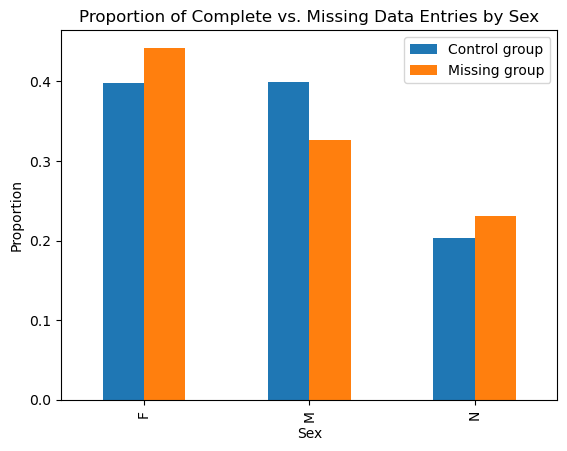

In [205]:
# This part groups the DataFrame "students" by the "sex" column and then counts the occurrences of each group. 
# It selects the 'uuid' column from the resulting DataFrame. So, it counts the number of non-null "uuid" entries for each group ("sex").
# Then it calculates the proportion of complete entries for each group by dividing the count of 'uuid' entries for each group by the total number of entries in the 'students' DataFrame.

sg = (df_students.groupby("sex").count()["uuid"] / len(df_students)).rename("Control group")
mg = (students_missing_courses.groupby("sex").count()["uuid"] / len(students_missing_courses)).rename("Missing group")
sg_mg = pd.concat([sg, mg], axis=1)

sg_mg.plot.bar()

plt.xlabel("Sex")
plt.ylabel("Proportion")
plt.title("Proportion of Complete vs. Missing Data Entries by Sex")
plt.legend()

plt.show()

By the same token, let's check if there any unusual distributions when it comes to job_id.

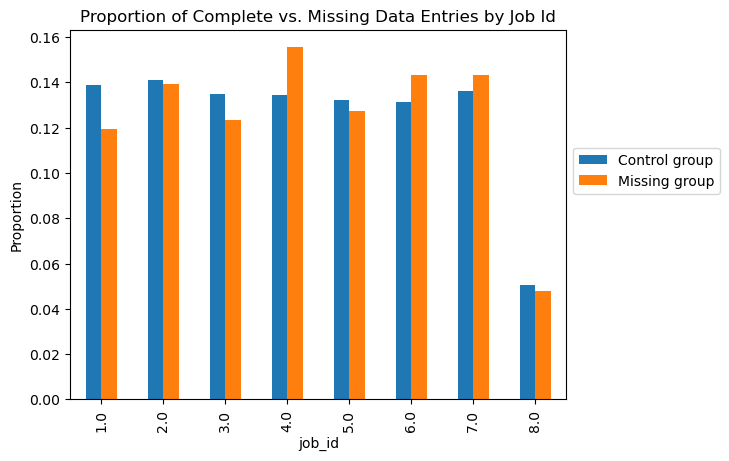

In [206]:
sg = (df_students.groupby("job_id").count()["uuid"] / len(df_students)).rename("Control group")
mg = (students_missing_courses.groupby("job_id").count()["uuid"] / len(students_missing_courses)).rename("Missing group")
sg_mg = pd.concat([sg, mg], axis=1)

sg_mg.plot.bar()

plt.xlabel("job_id")
plt.ylabel("Proportion")
plt.title("Proportion of Complete vs. Missing Data Entries by Job Id")
plt.legend(bbox_to_anchor=(1, 0.7))

plt.show()

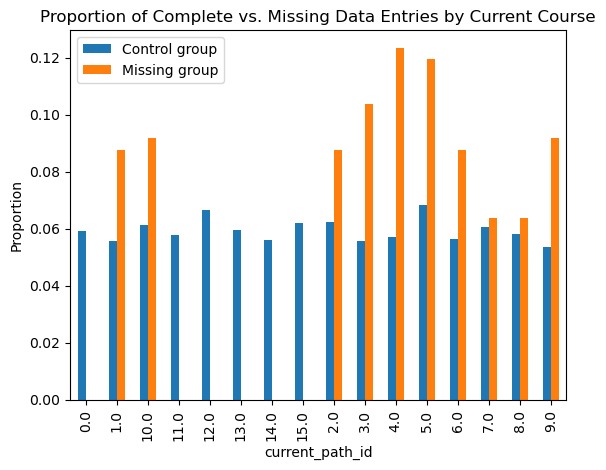

In [207]:
sg = (df_students.groupby("num_course_taken").count()["uuid"] / len(df_students)).rename("Control group")
mg = (students_missing_courses.groupby("current_career_path_id").count()["uuid"] / len(students_missing_courses)).rename("Missing group")
sg_mg = pd.concat([sg, mg], axis=1)

sg_mg.plot.bar()

plt.xlabel("current_path_id")
plt.ylabel("Proportion")
plt.title("Proportion of Complete vs. Missing Data Entries by Current Course")
#plt.legend(bbox_to_anchor=(1, 0.7))

plt.show()

Now this looks a bit unusual. We can see that some job ids are overrepresented, while some are completely missing. 
I decide to seperate those (statistically minor) missing course students into a different dataframe, so they don't affect analysis on the complete data but can be used for troubleshooting at a later stage.

In [208]:
students_missing_courses_backup = students_missing_courses.reset_index()
students_missing_courses_backup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   251 non-null    int64 
 1   uuid                    251 non-null    int64 
 2   name                    251 non-null    object
 3   dob                     251 non-null    object
 4   sex                     251 non-null    object
 5   job_id                  251 non-null    object
 6   num_course_taken        0 non-null      object
 7   current_career_path_id  231 non-null    object
 8   time_spent_hrs          231 non-null    object
 9   email                   251 non-null    object
 10  street                  251 non-null    object
 11  city                    251 non-null    object
 12  state                   251 non-null    object
 13  zip_code                251 non-null    object
dtypes: int64(2), object(12)
memory usage: 27.6+ KB


In [209]:
df_students = df_students.dropna(subset=["num_course_taken"])
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4749 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    4749 non-null   int64 
 1   name                    4749 non-null   object
 2   dob                     4749 non-null   object
 3   sex                     4749 non-null   object
 4   job_id                  4744 non-null   object
 5   num_course_taken        4749 non-null   object
 6   current_career_path_id  4298 non-null   object
 7   time_spent_hrs          4298 non-null   object
 8   email                   4749 non-null   object
 9   street                  4749 non-null   object
 10  city                    4749 non-null   object
 11  state                   4749 non-null   object
 12  zip_code                4749 non-null   object
dtypes: int64(1), object(12)
memory usage: 519.4+ KB


# Job ID and time spent
job_id is missing for only 5 entries. The choice is now: Delete them or let the analyst take care of it? I decide that at least for this iteration I delete them. The next patch/iteration might fix individual entries.

I decide to have one dataframe for all missing data.



In [210]:
missing_job_id = df_students[df_students["job_id"].isnull()].copy()
missing_job_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 162 to 1542
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5 non-null      int64 
 1   name                    5 non-null      object
 2   dob                     5 non-null      object
 3   sex                     5 non-null      object
 4   job_id                  0 non-null      object
 5   num_course_taken        5 non-null      object
 6   current_career_path_id  5 non-null      object
 7   time_spent_hrs          5 non-null      object
 8   email                   5 non-null      object
 9   street                  5 non-null      object
 10  city                    5 non-null      object
 11  state                   5 non-null      object
 12  zip_code                5 non-null      object
dtypes: int64(1), object(12)
memory usage: 560.0+ bytes


In [212]:
df_students2 = df_students.dropna(subset=["job_id"])
df_students2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    4744 non-null   int64 
 1   name                    4744 non-null   object
 2   dob                     4744 non-null   object
 3   sex                     4744 non-null   object
 4   job_id                  4744 non-null   object
 5   num_course_taken        4744 non-null   object
 6   current_career_path_id  4293 non-null   object
 7   time_spent_hrs          4293 non-null   object
 8   email                   4744 non-null   object
 9   street                  4744 non-null   object
 10  city                    4744 non-null   object
 11  state                   4744 non-null   object
 12  zip_code                4744 non-null   object
dtypes: int64(1), object(12)
memory usage: 518.9+ KB


In [216]:
df_students=df_students2
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    4744 non-null   int64 
 1   name                    4744 non-null   object
 2   dob                     4744 non-null   object
 3   sex                     4744 non-null   object
 4   job_id                  4744 non-null   object
 5   num_course_taken        4744 non-null   object
 6   current_career_path_id  4293 non-null   object
 7   time_spent_hrs          4293 non-null   object
 8   email                   4744 non-null   object
 9   street                  4744 non-null   object
 10  city                    4744 non-null   object
 11  state                   4744 non-null   object
 12  zip_code                4744 non-null   object
dtypes: int64(1), object(12)
memory usage: 518.9+ KB


In [213]:
missing_data = pd.DataFrame()
missing_data = pd.concat([students_missing_courses, missing_job_id])
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 25 to 1542
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    256 non-null    int64 
 1   name                    256 non-null    object
 2   dob                     256 non-null    object
 3   sex                     256 non-null    object
 4   job_id                  251 non-null    object
 5   num_course_taken        5 non-null      object
 6   current_career_path_id  236 non-null    object
 7   time_spent_hrs          236 non-null    object
 8   email                   256 non-null    object
 9   street                  256 non-null    object
 10  city                    256 non-null    object
 11  state                   256 non-null    object
 12  zip_code                256 non-null    object
dtypes: int64(1), object(12)
memory usage: 28.0+ KB


In [217]:
missing_path_id = df_students[df_students["current_career_path_id"].isnull()]
missing_path_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 15 to 4974
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    451 non-null    int64 
 1   name                    451 non-null    object
 2   dob                     451 non-null    object
 3   sex                     451 non-null    object
 4   job_id                  451 non-null    object
 5   num_course_taken        451 non-null    object
 6   current_career_path_id  0 non-null      object
 7   time_spent_hrs          0 non-null      object
 8   email                   451 non-null    object
 9   street                  451 non-null    object
 10  city                    451 non-null    object
 11  state                   451 non-null    object
 12  zip_code                451 non-null    object
dtypes: int64(1), object(12)
memory usage: 49.3+ KB


Time spent and path id taken corelate, which makes sense if the student is not taking any classes. The data is structurally missing and can be used.

In [218]:
df_students["current_career_path_id"].unique()

array(['1.0', '8.0', '9.0', '3.0', '6.0', '10.0', '5.0', None, '4.0',
       '7.0', '2.0'], dtype=object)

I will replace the "None" value with a 0. Datatypes will be fixed afterwards.


In [219]:
df_students['current_career_path_id'] = np.where(df_students['current_career_path_id'].isnull(), 0, df_students['current_career_path_id'])

df_students["current_career_path_id"].unique()

array(['1.0', '8.0', '9.0', '3.0', '6.0', '10.0', '5.0', 0, '4.0', '7.0',
       '2.0'], dtype=object)

In [220]:
#df_students[df_students["time_spent_hrs"].isnull()]
df_students["time_spent_hrs"] = np.where(df_students["time_spent_hrs"].isnull(), 0, df_students["time_spent_hrs"])
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    4744 non-null   int64 
 1   name                    4744 non-null   object
 2   dob                     4744 non-null   object
 3   sex                     4744 non-null   object
 4   job_id                  4744 non-null   object
 5   num_course_taken        4744 non-null   object
 6   current_career_path_id  4744 non-null   object
 7   time_spent_hrs          4744 non-null   object
 8   email                   4744 non-null   object
 9   street                  4744 non-null   object
 10  city                    4744 non-null   object
 11  state                   4744 non-null   object
 12  zip_code                4744 non-null   object
dtypes: int64(1), object(12)
memory usage: 518.9+ KB


In [228]:
df_students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


Let's remember we created a 0 for career path id, that should be represented in the respective courses table

In [229]:
df_courses

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [246]:
df_courses2 = df_courses.copy()
new_row =  pd.DataFrame({"career_path_id": [0], "career_path_name": ["N/A"], "hours_to_complete": [0]})
df_courses2= pd.concat([new_row, df_courses2], ignore_index=True)
df_courses = df_courses2
df_courses

,career_path_id,career_path_name,hours_to_complete
0,0,N/A,0
1,1,data scientist,20
2,2,data engineer,20
3,3,data analyst,12
4,4,software engineering,25
5,5,backend engineer,18
6,6,frontend engineer,20
7,7,iOS developer,27
8,8,android developer,27
9,9,machine learning engineer,35


That should suffice for now.

Now look at the data types, and entries themselves.


In [222]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    4744 non-null   int64 
 1   name                    4744 non-null   object
 2   dob                     4744 non-null   object
 3   sex                     4744 non-null   object
 4   job_id                  4744 non-null   object
 5   num_course_taken        4744 non-null   object
 6   current_career_path_id  4744 non-null   object
 7   time_spent_hrs          4744 non-null   object
 8   email                   4744 non-null   object
 9   street                  4744 non-null   object
 10  city                    4744 non-null   object
 11  state                   4744 non-null   object
 12  zip_code                4744 non-null   object
dtypes: int64(1), object(12)
memory usage: 518.9+ KB


Strings are slow AF, which shouldn't be an issue here, but I will cast categorical IDs to ints/floats

In [250]:
df_students2 = df_students.copy()

df_students2.job_id = df_students2.job_id.astype(float)
df_students2.current_career_path_id = df_students2.current_career_path_id.astype(float)
df_students2.num_course_taken = df_students2.num_course_taken.astype(float)
df_students2.time_spent_hrs = df_students2.time_spent_hrs.astype(float)
df_students = df_students2
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   email                   4744 non-null   object 
 9   street                  4744 non-null   object 
 10  city                    4744 non-null   object 
 11  state                   4744 non-null   object 
 12  zip_code                4744 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 518.9+ KB


I think we are good to go, if we notice some issues at a later stage of the pipeline we can always reiterate.

Ideal for analytics purposes would be "one big table" (OBT). For that, I join the tables (or rather dataframes) and create a OBT view/table in the database.

We might convert the floats to ints.

In [257]:
obt = df_students.merge(df_courses, left_on="current_career_path_id", right_on="career_path_id", how="left")
obt = obt.merge(df_student_jobs, on="job_id", how="left")
display(obt.head())
display(obt.info())


,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,email,street,city,state,zip_code,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.40,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4743
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   email                   4744 non-null   object 
 9   street                  4744 non-null   object 
 10  city                    4744 non-null   object 
 11  state                   4744 non-null   object 
 12  zip_code                4744 non-null   object 
 13  career_path_id          4744 non-null   int64  
 14  career_path_name        4744 non-null   

None

In [265]:
obt2 = obt.copy()
obt2.job_id = obt2.job_id.astype(int)
obt2.num_course_taken = obt2.num_course_taken.astype(int)
obt2.current_career_path_id= obt2.current_career_path_id.astype(int)
obt = obt2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4743
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int32  
 5   num_course_taken        4744 non-null   int32  
 6   current_career_path_id  4744 non-null   int32  
 7   time_spent_hrs          4744 non-null   float64
 8   email                   4744 non-null   object 
 9   street                  4744 non-null   object 
 10  city                    4744 non-null   object 
 11  state                   4744 non-null   object 
 12  zip_code                4744 non-null   object 
 13  career_path_id          4744 non-null   int64  
 14  career_path_name        4744 non-null   

In [279]:
obt.to_sql("main_cancelled_subscribers", con, if_exists="replace", index=False)
missing_data.to_sql("incomplete_data_subscribers", con, if_exists="replace", index=False)
control_df = pd.read_sql_query("SELECT * FROM main_cancelled_subscribers", con)
display(control_df.info())
control_df = pd.read_sql_query("SELECT * FROM incomplete_data_subscribers", con)
display(control_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   email                   4744 non-null   object 
 9   street                  4744 non-null   object 
 10  city                    4744 non-null   object 
 11  state                   4744 non-null   object 
 12  zip_code                4744 non-null   object 
 13  career_path_id          4744 non-null   int64  
 14  career_path_name        4744 non-null   

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    256 non-null    int64 
 1   name                    256 non-null    object
 2   dob                     256 non-null    object
 3   sex                     256 non-null    object
 4   job_id                  251 non-null    object
 5   num_course_taken        5 non-null      object
 6   current_career_path_id  236 non-null    object
 7   time_spent_hrs          236 non-null    object
 8   email                   256 non-null    object
 9   street                  256 non-null    object
 10  city                    256 non-null    object
 11  state                   256 non-null    object
 12  zip_code                256 non-null    object
dtypes: int64(1), object(12)
memory usage: 26.1+ KB


None

In [281]:
# Great success!
con.close()

In [280]:
obt.to_csv("main_cancelled_subscribers.csv")